In [44]:
import os
import json
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [46]:
def read_excel_auto(path):
    """Read Excel/CSV safely, normalize EU decimals & columns."""
    df = None
    try:
        df = pd.read_excel(path, engine="openpyxl")
        used_reader = "excel"
    except Exception:
        try:
            df = pd.read_csv(path, sep=";", engine="python")
            used_reader = "csv-; (semicolon)"
        except Exception:
            df = pd.read_csv(path, sep=",", engine="python")
            used_reader = "csv-, (comma)"
    print(f"✅ Loaded {path} using {used_reader}")

    # Normalize column names
    df.columns = [str(c).strip() for c in df.columns]

    # Ensure Date column
    if "Date" not in df.columns:
        for cand in ["date", "DATE", "Datetime", "Timestamp"]:
            if cand in df.columns:
                df.rename(columns={cand: "Date"}, inplace=True)

    # Fix EU number formatting
    for col in df.columns:
        if col == "Date":
            continue
        if df[col].dtype == object:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(".", "", regex=False)  # remove thousands separator
                .str.replace(",", ".", regex=False)  # fix decimal comma
            )
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Parse datetime
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

    return df

In [47]:
 
def add_time_features(df):
    step = (df["Date"].dt.hour * 60 + df["Date"].dt.minute) // 10
    df["mod"] = step.astype(int) #Runs from 0 (00:00) to 143 (23:50).
    df["mod_sin"] = np.sin(2 * np.pi * df["mod"] / 144)
    df["mod_cos"] = np.cos(2 * np.pi * df["mod"] / 144)
    dow = df["Date"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * np.pi * dow / 7)
    df["dow_cos"] = np.cos(2 * np.pi * dow / 7)
    return df

In [48]:
def add_lags_and_rolls(df, target_col="Energy (kWh)", max_lag=18):
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)
    for w in [6, 12, 18]:
        df[f"{target_col}_roll{w}"] = df[target_col].rolling(w).mean()
    return df

In [49]:
def make_features(df, target_col="Energy (kWh)"):
    df = add_time_features(df.copy())
    df = add_lags_and_rolls(df, target_col=target_col)

    # Add lags for Speed and Direction too
    for lag in range(1, 13):  # last 2 hours
        df[f"Speed_lag{lag}"] = df["Speed (m/s)"].shift(lag)
        df[f"Dir_lag{lag}"] = df["Direction (º)"].shift(lag)

    feature_cols = [c for c in df.columns if c not in ["Date", target_col]]
    df = df.dropna(subset=feature_cols + [target_col])
    X = df[feature_cols].values
    y = df[target_col].values
    return df, feature_cols, X, y

In [50]:
def train_model(train_df, target_col="Energy (kWh)"):
    df_feat, feat_cols, X, y = make_features(train_df, target_col=target_col)
    model = XGBRegressor(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2.0,
        objective="reg:squarederror",
        random_state=42,
    )
    model.fit(X, y)
    return model, feat_cols

In [51]:
def predict_next_day(model, hist_df, day_df, feat_cols, target_col="Energy (kWh)"):
    buffer = pd.Timedelta(hours=24)
    context = hist_df[hist_df["Date"] >= day_df["Date"].min() - buffer]
    combo = pd.concat([context, day_df], ignore_index=True).sort_values("Date")

    combo_feat, _, X_all, _ = make_features(combo, target_col=target_col)

    for col in feat_cols:
        if col not in combo_feat.columns:
            combo_feat[col] = np.nan

    combo_feat = combo_feat.dropna(subset=feat_cols)
    y_pred = model.predict(combo_feat[feat_cols].values)

    out = combo_feat[["Date"]].copy()
    out["predicted_energy"] = y_pred

    mask = (out["Date"] >= day_df["Date"].min()) & (out["Date"] <= day_df["Date"].max())
    return out[mask].reset_index(drop=True)

In [52]:
def evaluate(pred_df, actual_df, target_col="Energy (kWh)"):
    df = pd.merge(pred_df, actual_df[["Date", target_col]], on="Date", how="inner")
    y_true = df[target_col].values
    y_pred = df["predicted_energy"].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100

    # Add percentage difference column
    df["pct_diff(%)"] = (df["predicted_energy"] - df[target_col]) / df[target_col].clip(lower=1e-6) * 100

    return df, {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

✅ Loaded Sotavento_3month.xlsx using excel
✅ Loaded 17march.xlsx using excel
✅ Loaded 17march.xlsx using excel
📊 Evaluation: {'MAE': 143.11392328135173, 'RMSE': np.float64(236.7082094013399), 'MAPE(%)': np.float64(5374.421437770151)}
✅ Saved predictions with actuals and % difference → predictions_vs_actual_2020-03-17.xlsx


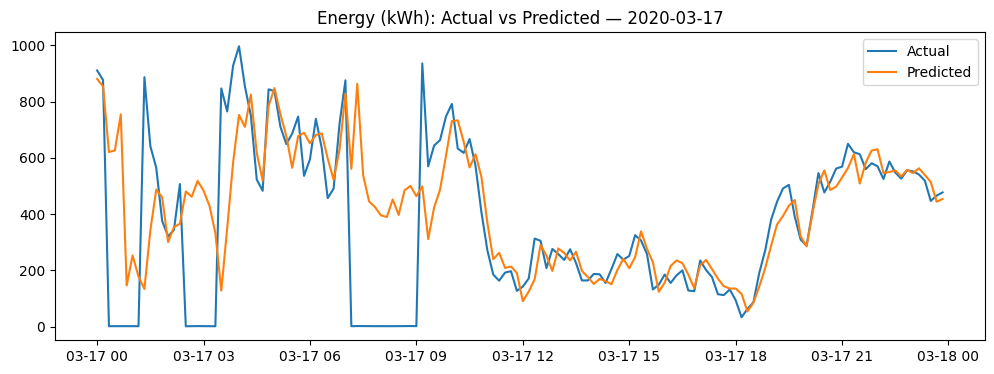

In [53]:
if __name__ == "__main__":
    train_file = "Sotavento_3month.xlsx"       # <-- your Jan 1 – Mar 16 Excel file
    test_file = "17march.xlsx"      # <-- actual Mar 17 Excel file (optional)

    train_df = read_excel_auto(train_file)

    # Find target column
    target_col = None
    for cand in ["Energy (kWh)", "Energy", "Energy(kWh)", "E. Aero (kWh)"]:
        if cand in train_df.columns:
            target_col = cand
            break
    if not target_col:
        raise ValueError("No Energy column found in dataset.")

    cutoff = pd.Timestamp(2020, 3, 16, 23, 50)
    train_cut = train_df[train_df["Date"] <= cutoff].copy()

    model, feat_cols = train_model(train_cut, target_col=target_col)

    # Prepare Mar 17 time grid if actual file not given
    if not os.path.exists(test_file):
        start = pd.Timestamp(2020, 3, 17, 0, 0)
        end = pd.Timestamp(2020, 3, 17, 23, 50)
        test_df = pd.DataFrame({"Date": pd.date_range(start, end, freq="10min")})
    else:
        test_df = read_excel_auto(test_file)

    preds = predict_next_day(model, train_cut, test_df, feat_cols, target_col=target_col)

if os.path.exists(test_file):
    actual_df = read_excel_auto(test_file)
    eval_df, metrics = evaluate(preds, actual_df, target_col=target_col)
    print("📊 Evaluation:", metrics)

    # Save comparison with percentage difference
    eval_df.to_excel("predictions_vs_actual_2020-03-17.xlsx", index=False)
    print("✅ Saved predictions with actuals and % difference → predictions_vs_actual_2020-03-17.xlsx")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(eval_df["Date"], eval_df[target_col], label="Actual")
    plt.plot(eval_df["Date"], eval_df["predicted_energy"], label="Predicted")
    plt.title("Energy (kWh): Actual vs Predicted — 2020-03-17")
    plt.legend()
    plt.show()